# Задача №4 "Сервис автоматического распределения задач для выездных сотрудников банка"

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from yandex_geocoder import Client
from ast import literal_eval
pd.set_option('display.max_columns', None)


In [2]:
RS = 42
client = Client('ваш ключ Yandex API Геокодер')

In [3]:
#Загрузка данных
#Данные по задачам для агентов
df_tasks = pd.read_excel('dataset.xlsx', sheet_name=1)
#Данные по филиалам и агентам
df_manager = pd.read_excel('dataset.xlsx', sheet_name=2)
#Данные по точкам
df_points = pd.read_excel('dataset.xlsx', sheet_name=0, na_filter=True)
#Данные по растоянию и времени 
df_dur = pd.read_csv('duration11.csv')

In [4]:
df_points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   № точки                                   42 non-null     int64  
 1   Адрес точки, г. Краснодар                 42 non-null     object 
 2   Когда подключена точка?                   40 non-null     object 
 3   Карты и материалы доставлены?             40 non-null     object 
 4   Кол-во дней после выдачи последней карты  40 non-null     float64
 5   Кол-во одобренных заявок                  40 non-null     float64
 6   Кол-во выданных карт                      40 non-null     float64
dtypes: float64(3), int64(1), object(3)
memory usage: 2.4+ KB


In [5]:
len(df_dur['Адрес точки, г. Краснодар_x'].value_counts()), len(df_dur['Адрес точки, г. Краснодар_y'].value_counts())

(46, 46)

In [6]:
df_dur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2440 entries, 0 to 2439
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Адрес точки, г. Краснодар_x  2440 non-null   object 
 1   lat_x                        2440 non-null   float64
 2   lon_x                        2440 non-null   float64
 3   Адрес точки, г. Краснодар_y  2440 non-null   object 
 4   lat_y                        2440 non-null   float64
 5   lon_y                        2440 non-null   float64
 6   summary                      2440 non-null   object 
 7   length                       2440 non-null   float64
 8   duration                     2440 non-null   float64
dtypes: float64(6), object(3)
memory usage: 171.7+ KB


In [7]:
#Создаем матрицы растояний и времени
df_pivot_length = pd.pivot_table(
    df_dur, 
    values='length', 
    index=['Адрес точки, г. Краснодар_x'], 
    columns=['Адрес точки, г. Краснодар_y'], 
    aggfunc=lambda x: x
    )
df_pivot_dur = pd.pivot_table(
    df_dur, 
    values='duration', 
    index=['Адрес точки, г. Краснодар_x'], 
    columns=['Адрес точки, г. Краснодар_y'], 
    aggfunc=lambda x: x
    )
df_pivot_length.head()

"Адрес точки, г. Краснодар_y","Краснодар, В.Н. Мачуги, 41","Краснодар, Красная, д. 139","Краснодар, Красных Партизан, 321","п. Березовый, ул. Целиноградская, д. 6/1","ст-ца. Елизаветинская, ул. Широкая, д. 260","тер. Пашковский жилой массив, ул. Крылатая, д. 2","ул. 1-го Мая, д. 268","ул. Восточно-Кругликовская, д. 64/2","ул. Зиповская, д. 1","ул. Коммунаров, д. 258","ул. Красная, д. 145","ул. Красная, д. 149","ул. Красная, д. 154","ул. Красная, д. 176","ул. Красноармейская, д. 126","ул. Красных Партизан, д. 117","ул. Красных Партизан, д. 439","ул. Российская, д. 418","ул. Северная, д. 326","ул. Северная, д. 327","ул. Северная, д. 389","ул. Северная, д. 524","ул. Ставропольская, д. 140","ул. Таманская, д. 153 к. 3, кв. 2","ул. Уральская, д. 117","ул. Уральская, д. 162","ул. Уральская, д. 166/3","ул. Уральская, д. 78","ул. Уральская, д. 79/1","ул. им. 40-летия Победы, д. 20/1","ул. им. 40-летия Победы, д. 34","ул. им. Атарбекова, д. 24","ул. им. Володи Головатого, д. 313","ул. им. Героя Аверкиева А.А., д. 8","ул. им. Героя Аверкиева А.А., д. 8/1 к. мая, кв. 268","ул. им. Дзержинского, д. 100","ул. им. Дзержинского, д. 101","ул. им. Дзержинского, д. 102","ул. им. Дзержинского, д. 165","ул. им. Кирилла Россинского, д. 61/1","ул. им. Максима Горького, д. 128","ул. им. Селезнева, д. 197/5","ул. им. Селезнева, д. 76","ул. им. Тургенева, д. 106","ул. им. Тургенева, д. 174, 1 этаж","х. Ленина, п/о. 37"
"Адрес точки, г. Краснодар_x",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Краснодар, В.Н. Мачуги, 41",NaN,10.89,13.77,28.43,27.47,6.64,12.34,12.75,13.92,11.68,12.34,13.0,10.04,12.21,10.02,17.47,14.23,15.02,"[10.69, 10.69]",9.7,10.12,9.51,6.3,5.24,5.46,5.57,5.67,5.93,"[5.31, 5.31]",12.72,12.9,16.12,11.96,11.79,11.79,"[19.59, 19.59, 19.59]",14.81,20.15,17.6,16.37,8.81,1.89,4.35,14.14,16.2,16.05
"Краснодар, Красная, д. 139",11.15,NaN,4.14,18.24,16.56,18.75,7.36,8.22,3.73,1.34,1.08,1.73,1.31,0.94,1.29,6.56,3.32,7.96,"[1.61, 1.61]",1.88,2.03,2.63,7.5,9.0,10.14,10.43,10.53,5.68,"[7.25, 7.25]",4.52,4.7,5.22,1.05,7.22,7.22,"[8.2, 8.2, 8.2]",5.13,10.4,6.22,10.22,2.18,9.07,5.54,3.23,5.28,28.16
"Краснодар, Красных Партизан, 321",16.83,4.03,NaN,17.67,12.2,40.44,9.51,10.38,5.89,5.19,3.98,3.7,4.82,4.1,4.79,2.21,1.55,10.11,"[3.99, 3.99]",5.79,5.91,6.51,10.14,11.64,14.02,14.31,14.39,9.94,"[11.13, 11.13]",6.67,6.85,1.14,4.21,9.38,9.38,"[8.25, 8.25, 8.25]",4.03,10.22,6.27,12.38,5.76,12.95,9.42,2.11,3.83,49.84
"п. Березовый, ул. Целиноградская, д. 6/1",22.59,12.21,12.98,NaN,23.65,34.84,10.91,11.78,12.28,12.91,12.88,12.59,14.16,13.0,14.14,15.12,12.04,8.22,"[14.46, 14.46]",14.3,14.35,14.55,19.04,19.36,22.06,22.35,22.45,17.12,"[19.17, 19.17]",12.77,12.64,11.88,13.9,12.12,12.12,"[7.37, 7.37, 7.37]",9.28,6.42,6.92,9.75,14.61,19.84,17.46,12.2,10.31,44.25
"ст-ца. Елизаветинская, ул. Широкая, д. 260",26.75,15.9,12.85,23.91,NaN,31.33,21.7,22.57,18.46,17.22,16.0,15.71,16.57,16.14,16.54,10.94,13.63,24.38,"[15.73, 15.73]",17.13,17.62,18.23,21.45,22.71,25.73,26.02,26.12,21.27,"[22.84, 22.84]",18.47,18.65,13.44,15.95,21.17,21.17,"[20.93, 20.93, 20.93]",16.37,19.67,20.48,26.74,17.47,23.52,21.14,14.12,16.43,40.74


In [8]:
len(df_pivot_length.columns), len(df_pivot_length)

(46, 46)

In [9]:
#исправляем адреса в соотвествии с новыми требованиями по адресам
def get_one_value(df, adress_list):
    for adress in adress_list:
        df.loc[adress] = df[adress].apply(
            lambda x: x[0] if type(x) == np.ndarray else x
        )
    for adress in adress_list:
        df[adress] = df[adress].apply(
            lambda x: x[0] if type(x) == np.ndarray else x
        )

    return df

In [10]:
#исправляем адреса в соотвествии с новыми требованиями по адресам
df_pivot_length = get_one_value(df_pivot_length, ['ул. Северная, д. 326', 'ул. им. Дзержинского, д. 100', 'ул. Уральская, д. 79/1'])
df_pivot_dur = get_one_value(df_pivot_dur, ['ул. Северная, д. 326', 'ул. им. Дзержинского, д. 100', 'ул. Уральская, д. 79/1'])
df_pivot_dur.head()

"Адрес точки, г. Краснодар_y","Краснодар, В.Н. Мачуги, 41","Краснодар, Красная, д. 139","Краснодар, Красных Партизан, 321","п. Березовый, ул. Целиноградская, д. 6/1","ст-ца. Елизаветинская, ул. Широкая, д. 260","тер. Пашковский жилой массив, ул. Крылатая, д. 2","ул. 1-го Мая, д. 268","ул. Восточно-Кругликовская, д. 64/2","ул. Зиповская, д. 1","ул. Коммунаров, д. 258","ул. Красная, д. 145","ул. Красная, д. 149","ул. Красная, д. 154","ул. Красная, д. 176","ул. Красноармейская, д. 126","ул. Красных Партизан, д. 117","ул. Красных Партизан, д. 439","ул. Российская, д. 418","ул. Северная, д. 326","ул. Северная, д. 327","ул. Северная, д. 389","ул. Северная, д. 524","ул. Ставропольская, д. 140","ул. Таманская, д. 153 к. 3, кв. 2","ул. Уральская, д. 117","ул. Уральская, д. 162","ул. Уральская, д. 166/3","ул. Уральская, д. 78","ул. Уральская, д. 79/1","ул. им. 40-летия Победы, д. 20/1","ул. им. 40-летия Победы, д. 34","ул. им. Атарбекова, д. 24","ул. им. Володи Головатого, д. 313","ул. им. Героя Аверкиева А.А., д. 8","ул. им. Героя Аверкиева А.А., д. 8/1 к. мая, кв. 268","ул. им. Дзержинского, д. 100","ул. им. Дзержинского, д. 101","ул. им. Дзержинского, д. 102","ул. им. Дзержинского, д. 165","ул. им. Кирилла Россинского, д. 61/1","ул. им. Максима Горького, д. 128","ул. им. Селезнева, д. 197/5","ул. им. Селезнева, д. 76","ул. им. Тургенева, д. 106","ул. им. Тургенева, д. 174, 1 этаж","х. Ленина, п/о. 37"
"Адрес точки, г. Краснодар_x",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Краснодар, В.Н. Мачуги, 41",NaN,0.51,0.61,0.88,0.97,0.22,0.55,0.5,0.69,0.51,0.54,0.56,0.54,0.53,0.53,0.79,0.62,0.64,0.56,0.39,0.43,0.4,0.36,0.32,0.23,0.23,0.23,0.28,0.23,0.53,0.54,0.71,0.57,0.47,0.47,0.81,0.66,0.79,0.74,0.72,0.48,0.12,0.29,0.63,0.69,0.35
"Краснодар, Красная, д. 139",0.53,NaN,0.21,0.45,0.48,0.65,0.32,0.35,0.27,0.08,0.07,0.1,0.1,0.06,0.09,0.29,0.15,0.32,0.09,0.13,0.11,0.12,0.32,0.39,0.47,0.48,0.49,0.32,0.39,0.18,0.19,0.22,0.07,0.3,0.3,0.35,0.25,0.37,0.28,0.42,0.14,0.47,0.28,0.14,0.22,0.78
"Краснодар, Красных Партизан, 321",0.61,0.19,NaN,0.51,0.31,0.7,0.41,0.45,0.36,0.22,0.18,0.17,0.21,0.19,0.21,0.12,0.06,0.42,0.15,0.26,0.24,0.25,0.41,0.49,0.6,0.61,0.62,0.47,0.52,0.28,0.28,0.06,0.17,0.4,0.4,0.33,0.16,0.42,0.26,0.52,0.24,0.6,0.41,0.1,0.15,0.83
"п. Березовый, ул. Целиноградская, д. 6/1",0.56,0.27,0.3,NaN,0.48,0.54,0.26,0.29,0.26,0.28,0.27,0.26,0.34,0.28,0.33,0.36,0.29,0.18,0.34,0.32,0.33,0.34,0.46,0.47,0.53,0.55,0.55,0.43,0.48,0.27,0.27,0.28,0.32,0.3,0.3,0.18,0.2,0.13,0.15,0.27,0.35,0.47,0.41,0.31,0.24,0.66
"ст-ца. Елизаветинская, ул. Широкая, д. 260",0.64,0.36,0.26,0.5,NaN,0.79,0.54,0.57,0.45,0.41,0.35,0.35,0.39,0.36,0.38,0.21,0.28,0.49,0.34,0.4,0.42,0.43,0.49,0.53,0.62,0.63,0.64,0.5,0.57,0.45,0.46,0.29,0.35,0.56,0.56,0.43,0.38,0.38,0.39,0.58,0.41,0.57,0.5,0.29,0.36,0.88


In [11]:
#Удаляем не коректные адреса
df_pivot_length = df_pivot_length.drop('ул. им. Героя Аверкиева А.А., д. 8/1 к. мая, кв. 268', axis=0)
df_pivot_length = df_pivot_length.drop('ул. им. Героя Аверкиева А.А., д. 8/1 к. мая, кв. 268', axis=1)
df_pivot_dur = df_pivot_dur.drop('ул. им. Героя Аверкиева А.А., д. 8/1 к. мая, кв. 268', axis=0)
df_pivot_dur = df_pivot_dur.drop('ул. им. Героя Аверкиева А.А., д. 8/1 к. мая, кв. 268', axis=1)
df_pivot_length

"Адрес точки, г. Краснодар_y","Краснодар, В.Н. Мачуги, 41","Краснодар, Красная, д. 139","Краснодар, Красных Партизан, 321","п. Березовый, ул. Целиноградская, д. 6/1","ст-ца. Елизаветинская, ул. Широкая, д. 260","тер. Пашковский жилой массив, ул. Крылатая, д. 2","ул. 1-го Мая, д. 268","ул. Восточно-Кругликовская, д. 64/2","ул. Зиповская, д. 1","ул. Коммунаров, д. 258","ул. Красная, д. 145","ул. Красная, д. 149","ул. Красная, д. 154","ул. Красная, д. 176","ул. Красноармейская, д. 126","ул. Красных Партизан, д. 117","ул. Красных Партизан, д. 439","ул. Российская, д. 418","ул. Северная, д. 326","ул. Северная, д. 327","ул. Северная, д. 389","ул. Северная, д. 524","ул. Ставропольская, д. 140","ул. Таманская, д. 153 к. 3, кв. 2","ул. Уральская, д. 117","ул. Уральская, д. 162","ул. Уральская, д. 166/3","ул. Уральская, д. 78","ул. Уральская, д. 79/1","ул. им. 40-летия Победы, д. 20/1","ул. им. 40-летия Победы, д. 34","ул. им. Атарбекова, д. 24","ул. им. Володи Головатого, д. 313","ул. им. Героя Аверкиева А.А., д. 8","ул. им. Дзержинского, д. 100","ул. им. Дзержинского, д. 101","ул. им. Дзержинского, д. 102","ул. им. Дзержинского, д. 165","ул. им. Кирилла Россинского, д. 61/1","ул. им. Максима Горького, д. 128","ул. им. Селезнева, д. 197/5","ул. им. Селезнева, д. 76","ул. им. Тургенева, д. 106","ул. им. Тургенева, д. 174, 1 этаж","х. Ленина, п/о. 37"
"Адрес точки, г. Краснодар_x",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Краснодар, В.Н. Мачуги, 41",NaN,10.89,13.77,28.43,27.47,6.64,12.34,12.75,13.92,11.68,12.34,13.0,10.04,12.21,10.02,17.47,14.23,15.02,10.69,9.7,10.12,9.51,6.3,5.24,5.46,5.57,5.67,5.93,5.31,12.72,12.9,16.12,11.96,11.79,19.59,14.81,20.15,17.6,16.37,8.81,1.89,4.35,14.14,16.2,16.05
"Краснодар, Красная, д. 139",11.15,NaN,4.14,18.24,16.56,18.75,7.36,8.22,3.73,1.34,1.08,1.73,1.31,0.94,1.29,6.56,3.32,7.96,1.61,1.88,2.03,2.63,7.5,9.0,10.14,10.43,10.53,5.68,7.25,4.52,4.7,5.22,1.05,7.22,8.20,5.13,10.4,6.22,10.22,2.18,9.07,5.54,3.23,5.28,28.16
"Краснодар, Красных Партизан, 321",16.83,4.03,NaN,17.67,12.2,40.44,9.51,10.38,5.89,5.19,3.98,3.7,4.82,4.1,4.79,2.21,1.55,10.11,3.99,5.79,5.91,6.51,10.14,11.64,14.02,14.31,14.39,9.94,11.13,6.67,6.85,1.14,4.21,9.38,8.25,4.03,10.22,6.27,12.38,5.76,12.95,9.42,2.11,3.83,49.84
"п. Березовый, ул. Целиноградская, д. 6/1",22.59,12.21,12.98,NaN,23.65,34.84,10.91,11.78,12.28,12.91,12.88,12.59,14.16,13.0,14.14,15.12,12.04,8.22,14.46,14.3,14.35,14.55,19.04,19.36,22.06,22.35,22.45,17.12,19.17,12.77,12.64,11.88,13.9,12.12,7.37,9.28,6.42,6.92,9.75,14.61,19.84,17.46,12.2,10.31,44.25
"ст-ца. Елизаветинская, ул. Широкая, д. 260",26.75,15.9,12.85,23.91,NaN,31.33,21.7,22.57,18.46,17.22,16.0,15.71,16.57,16.14,16.54,10.94,13.63,24.38,15.73,17.13,17.62,18.23,21.45,22.71,25.73,26.02,26.12,21.27,22.84,18.47,18.65,13.44,15.95,21.17,20.93,16.37,19.67,20.48,26.74,17.47,23.52,21.14,14.12,16.43,40.74
"тер. Пашковский жилой массив, ул. Крылатая, д. 2",5.71,15.56,18.49,39.31,30.56,NaN,15.45,15.84,17.19,14.77,15.45,16.1,15.21,15.31,15.19,20.57,17.31,18.11,15.86,13.8,13.22,12.61,11.93,10.8,8.55,8.38,8.3,10.14,12.06,15.66,15.37,19.14,15.06,14.89,22.02,18.7,23.08,20.04,24.22,13.98,7.45,9.75,17.23,19.54,10.58
"ул. 1-го Мая, д. 268",10.94,6.94,9.53,15.51,21.58,15.52,NaN,0.87,3.17,6.86,6.82,6.54,7.2,6.95,7.17,11.58,8.26,2.69,8.58,6.62,5.79,5.43,8.04,7.22,9.92,10.21,10.31,5.46,7.03,2.95,2.69,10.29,7.85,1.21,10.60,8.12,9.65,10.15,4.09,7.37,7.71,5.33,8.21,8.72,24.93
"ул. Восточно-Кругликовская, д. 64/2",11.48,7.37,9.96,15.59,22.51,16.07,0.93,NaN,4.1,7.79,7.75,7.47,8.36,7.88,8.34,12.51,9.19,2.77,9.51,7.17,6.59,5.98,8.59,7.77,10.47,10.76,10.86,6.01,7.58,3.88,3.62,9.9,8.43,1.76,11.53,8.55,10.58,11.08,4.17,8.54,8.26,5.88,9.14,9.65,25.48
"ул. Зиповская, д. 1",12.03,2.43,5.02,15.44,17.06,16.61,4.95,5.82,NaN,2.34,2.31,2.03,3.87,2.43,3.85,7.07,3.75,5.16,4.07,3.73,3.79,3.99,8.47,8.31,11.01,11.3,11.4,6.55,8.12,2.2,2.38,5.78,3.33,4.9,6.93,3.6,7.6,4.94,7.42,4.05,8.8,6.42,3.69,4.21,26.02


In [12]:
df_pivot_dur.loc['ул. им. Дзержинского, д. 100'][0]

0.81

In [13]:
#меняем названия офисов банка
df_pivot_length = df_pivot_length.rename(columns={
    'Краснодар, Красная, д. 139' : 'офис_1', 
    'Краснодар, В.Н. Мачуги, 41' : 'офис_2', 
    'Краснодар, Красных Партизан, 321' : 'офис_3'})
# Удаляем строки со значением офисов банка
df_pivot_length = df_pivot_length.drop(index=['Краснодар, Красная, д. 139', 'Краснодар, В.Н. Мачуги, 41', 'Краснодар, Красных Партизан, 321'])

#меняем названия офисов банка
df_pivot_dur = df_pivot_dur.rename(columns={
    'Краснодар, Красная, д. 139' : 'офис_1', 
    'Краснодар, В.Н. Мачуги, 41' : 'офис_2', 
    'Краснодар, Красных Партизан, 321' : 'офис_3'})
# Удаляем строки со значением офисов банка
df_pivot_dur = df_pivot_dur.drop(index=['Краснодар, Красная, д. 139', 'Краснодар, В.Н. Мачуги, 41', 'Краснодар, Красных Партизан, 321'])
df_pivot_length

"Адрес точки, г. Краснодар_y",офис_2,офис_1,офис_3,"п. Березовый, ул. Целиноградская, д. 6/1","ст-ца. Елизаветинская, ул. Широкая, д. 260","тер. Пашковский жилой массив, ул. Крылатая, д. 2","ул. 1-го Мая, д. 268","ул. Восточно-Кругликовская, д. 64/2","ул. Зиповская, д. 1","ул. Коммунаров, д. 258","ул. Красная, д. 145","ул. Красная, д. 149","ул. Красная, д. 154","ул. Красная, д. 176","ул. Красноармейская, д. 126","ул. Красных Партизан, д. 117","ул. Красных Партизан, д. 439","ул. Российская, д. 418","ул. Северная, д. 326","ул. Северная, д. 327","ул. Северная, д. 389","ул. Северная, д. 524","ул. Ставропольская, д. 140","ул. Таманская, д. 153 к. 3, кв. 2","ул. Уральская, д. 117","ул. Уральская, д. 162","ул. Уральская, д. 166/3","ул. Уральская, д. 78","ул. Уральская, д. 79/1","ул. им. 40-летия Победы, д. 20/1","ул. им. 40-летия Победы, д. 34","ул. им. Атарбекова, д. 24","ул. им. Володи Головатого, д. 313","ул. им. Героя Аверкиева А.А., д. 8","ул. им. Дзержинского, д. 100","ул. им. Дзержинского, д. 101","ул. им. Дзержинского, д. 102","ул. им. Дзержинского, д. 165","ул. им. Кирилла Россинского, д. 61/1","ул. им. Максима Горького, д. 128","ул. им. Селезнева, д. 197/5","ул. им. Селезнева, д. 76","ул. им. Тургенева, д. 106","ул. им. Тургенева, д. 174, 1 этаж","х. Ленина, п/о. 37"
"Адрес точки, г. Краснодар_x",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"п. Березовый, ул. Целиноградская, д. 6/1",22.59,12.21,12.98,NaN,23.65,34.84,10.91,11.78,12.28,12.91,12.88,12.59,14.16,13.0,14.14,15.12,12.04,8.22,14.46,14.3,14.35,14.55,19.04,19.36,22.06,22.35,22.45,17.12,19.17,12.77,12.64,11.88,13.9,12.12,7.37,9.28,6.42,6.92,9.75,14.61,19.84,17.46,12.2,10.31,44.25
"ст-ца. Елизаветинская, ул. Широкая, д. 260",26.75,15.9,12.85,23.91,NaN,31.33,21.7,22.57,18.46,17.22,16.0,15.71,16.57,16.14,16.54,10.94,13.63,24.38,15.73,17.13,17.62,18.23,21.45,22.71,25.73,26.02,26.12,21.27,22.84,18.47,18.65,13.44,15.95,21.17,20.93,16.37,19.67,20.48,26.74,17.47,23.52,21.14,14.12,16.43,40.74
"тер. Пашковский жилой массив, ул. Крылатая, д. 2",5.71,15.56,18.49,39.31,30.56,NaN,15.45,15.84,17.19,14.77,15.45,16.1,15.21,15.31,15.19,20.57,17.31,18.11,15.86,13.8,13.22,12.61,11.93,10.8,8.55,8.38,8.3,10.14,12.06,15.66,15.37,19.14,15.06,14.89,22.02,18.7,23.08,20.04,24.22,13.98,7.45,9.75,17.23,19.54,10.58
"ул. 1-го Мая, д. 268",10.94,6.94,9.53,15.51,21.58,15.52,NaN,0.87,3.17,6.86,6.82,6.54,7.2,6.95,7.17,11.58,8.26,2.69,8.58,6.62,5.79,5.43,8.04,7.22,9.92,10.21,10.31,5.46,7.03,2.95,2.69,10.29,7.85,1.21,10.60,8.12,9.65,10.15,4.09,7.37,7.71,5.33,8.21,8.72,24.93
"ул. Восточно-Кругликовская, д. 64/2",11.48,7.37,9.96,15.59,22.51,16.07,0.93,NaN,4.1,7.79,7.75,7.47,8.36,7.88,8.34,12.51,9.19,2.77,9.51,7.17,6.59,5.98,8.59,7.77,10.47,10.76,10.86,6.01,7.58,3.88,3.62,9.9,8.43,1.76,11.53,8.55,10.58,11.08,4.17,8.54,8.26,5.88,9.14,9.65,25.48
"ул. Зиповская, д. 1",12.03,2.43,5.02,15.44,17.06,16.61,4.95,5.82,NaN,2.34,2.31,2.03,3.87,2.43,3.85,7.07,3.75,5.16,4.07,3.73,3.79,3.99,8.47,8.31,11.01,11.3,11.4,6.55,8.12,2.2,2.38,5.78,3.33,4.9,6.93,3.6,7.6,4.94,7.42,4.05,8.8,6.42,3.69,4.21,26.02
"ул. Коммунаров, д. 258",10.67,1.68,4.62,17.34,17.16,14.77,6.41,7.28,3.61,NaN,1.56,1.28,1.53,1.54,1.51,7.17,3.48,7.06,2.18,1.39,1.55,2.16,6.13,6.96,9.66,9.95,10.05,5.2,6.77,3.62,3.8,5.42,1.6,6.32,8.39,4.92,9.5,6.4,9.32,1.71,7.44,5.06,3.77,5.61,24.17
"ул. Красная, д. 145",11.57,1.21,3.19,16.64,15.33,15.66,7.21,8.08,4.37,1.75,NaN,0.81,1.72,1.21,1.7,5.33,2.01,7.81,1.85,2.4,2.44,3.05,7.02,7.85,10.55,10.85,10.95,6.09,7.67,4.38,4.55,3.56,1.14,7.08,7.22,4.25,9.76,5.24,10.08,2.6,8.34,5.96,1.92,3.96,25.07
"ул. Красная, д. 149",11.55,0.54,3.52,17.71,15.66,15.64,6.96,7.83,4.11,1.9,0.42,NaN,1.71,0.55,1.69,5.66,2.34,7.56,2.02,2.38,2.43,3.03,7.0,7.84,10.54,10.83,10.93,6.07,7.65,4.12,4.3,3.88,1.45,6.82,7.55,4.57,9.78,5.57,9.82,2.58,8.32,5.94,2.25,4.29,25.05


In [14]:
#Создаем столбцы для соедеения таблиц
df_pivot_length = df_pivot_length.reset_index()
df_pivot_length = df_pivot_length.rename(columns={'Адрес точки, г. Краснодар_x' : 'Адрес точки, г. Краснодар'})
df_pivot_dur = df_pivot_dur.reset_index()
df_pivot_dur = df_pivot_dur.rename(columns={'Адрес точки, г. Краснодар_x' : 'Адрес точки, г. Краснодар'})

In [15]:
#Данные по задачам
df_tasks

,Тип,Название задачи,Приоритет,Время выполнения,Условие назначения 1,Условие назначения 2,Требуемый уровень сотрудника
0,1,Выезд на точку для стимулирования выдач,Высокий,4 часа,Дата выдачи последней карты более 7 дней назад...,Дата выдачи последней карты более 14 дней назад,Только синьор
1,2,Обучение агента,Средний,2 часа,Отношение кол-ва выданных карт к одобренным за...,-,Синьор или мидл
2,3,Доставка карт и материалов,Низкий,"1,5 часа",Точка подключена вчера,Карты и материалы не доставлялись,Все уровни


In [16]:
#Данные по агентам
df_manager

,ФИО,Адрес локации,Грейд
0,Дерягин Никита Владимирович,"Краснодар, Красная, д. 139",Синьор
1,Петрошев Валерий Павлович,"Краснодар, Красная, д. 139",Мидл
2,Евдокимов Давид Тихонович,"Краснодар, Красная, д. 139",Джун
3,Андреев Гордий Данилович,"Краснодар, В.Н. Мачуги, 41",Синьор
4,Иванов Адам Федорович,"Краснодар, В.Н. Мачуги, 41",Мидл
5,Бобылёв Ипполит Альбертович,"Краснодар, В.Н. Мачуги, 41",Джун
6,Беляева Евгения Антоновна,"Краснодар, Красных Партизан, 321",Мидл
7,Николаев Азарий Платонович,"Краснодар, Красных Партизан, 321",Джун


In [17]:
df_pivot_length.to_csv('4_ver_df_pivot_length.csv')
df_pivot_dur.to_csv('4_ver_df_pivot_dur.csv')

## Обработка датасета, добавления признаков

In [18]:
#Задачи в разрезе грейдов
graide_dict = {'Синьор': '1, 2, 3', 'Мидл': '2, 3', 'Джун': '3'}
graide_dict

{'Синьор': '1, 2, 3', 'Мидл': '2, 3', 'Джун': '3'}

In [19]:
#Добавляем новые признаки в таблицу агентов
df_manager["функции"] = df_manager['Грейд'].map(graide_dict)
df_manager["офис"] = df_manager['Адрес локации'].map(
    {'Краснодар, Красная, д. 139' : 'офис_1',
    'Краснодар, В.Н. Мачуги, 41' : 'офис_2',
    'Краснодар, Красных Партизан, 321' : 'офис_3'})
df_manager['coordinates'] = df_manager['Адрес локации'].map(
    lambda x:  client.coordinates(x))
df_manager['lat'] = df_manager.coordinates.map(lambda x: x[1])
df_manager['lon'] = df_manager.coordinates.map(lambda x: x[0])
df_manager

,ФИО,Адрес локации,Грейд,функции,офис,coordinates,lat,lon
0,Дерягин Никита Владимирович,"Краснодар, Красная, д. 139",Синьор,"1, 2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047
1,Петрошев Валерий Павлович,"Краснодар, Красная, д. 139",Мидл,"2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047
2,Евдокимов Давид Тихонович,"Краснодар, Красная, д. 139",Джун,3,офис_1,"(38.977047, 45.04496)",45.04496,38.977047
3,Андреев Гордий Данилович,"Краснодар, В.Н. Мачуги, 41",Синьор,"1, 2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711
4,Иванов Адам Федорович,"Краснодар, В.Н. Мачуги, 41",Мидл,"2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711
5,Бобылёв Ипполит Альбертович,"Краснодар, В.Н. Мачуги, 41",Джун,3,офис_2,"(39.071711, 45.012835)",45.012835,39.071711
6,Беляева Евгения Антоновна,"Краснодар, Красных Партизан, 321",Мидл,"2, 3",офис_3,"(38.941986, 45.053773)",45.053773,38.941986
7,Николаев Азарий Платонович,"Краснодар, Красных Партизан, 321",Джун,3,офис_3,"(38.941986, 45.053773)",45.053773,38.941986


In [20]:
#считает часы на точке и кто из грейдов может ехать
def total_func(row, hours=False):
    if hours:
        res = 0.0
    else:
        res = ''
    if row['функция_3'] == 1:
        if hours:
            res += 1.5
        else:
            res = '1,2,3'
    if row['функция_2'] == 1:
        if hours:
            res += 2
        else:
            res = '1,2'
        
    if row['функция_1'] == 1:
        if hours:
            res += 4
        else:
            res = '1'
          
    return res

In [21]:
#Добавляем новые признаки в таблицу с точками продаж
#Удаляем лишнии адреса
#df_points = df_points.drop(index=[16, 17])
#расчитываем и добавляем данные по состоянию точек
df_points['одобренные но не выданные карты'] = (
    df_points['Кол-во одобренных заявок'] - df_points['Кол-во выданных карт']
    )
df_points['переход со вчерашнего дня'] = 0
df_points['функция_1'] = (
    ((df_points['Кол-во дней после выдачи последней карты'] > 7) & 
    (df_points['Кол-во одобренных заявок'] > 0)) | 
    (df_points['Кол-во дней после выдачи последней карты'] > 14)) * 1 
df_points.loc[5, 'функция_1'] = 0

df_points['функция_2'] = (
    (df_points['Кол-во выданных карт'] > 0) & 
    (df_points['Кол-во выданных карт'] / 
    df_points['Кол-во одобренных заявок'] < 0.5)) * 1
df_points['функция_3'] = (
    (df_points['Когда подключена точка?'] == 'вчера') |
    (df_points['Карты и материалы доставлены?'] == 'нет')) * 1

#добаляем часы на точке и кто может ехать
df_points['кто может ехать'] = (
    df_points[['функция_1', 'функция_2', 'функция_3']].apply(total_func, axis=1)
)
df_points['кол-во часов на точке'] = (
    df_points[['функция_1', 'функция_2', 'функция_3']]
    .apply(lambda x: total_func(x, hours=True), axis=1)
)

#Добавляем координаты
df_points['coordinates'] = (
    df_points['Адрес точки, г. Краснодар']
    .map(lambda x:  client.coordinates(f'Краснодар, {x}')))
df_points['lat'] = df_points.coordinates.map(lambda x: x[1])
df_points['lon'] = df_points.coordinates.map(lambda x: x[0])
df_points

,№ точки,"Адрес точки, г. Краснодар",Когда подключена точка?,Карты и материалы доставлены?,Кол-во дней после выдачи последней карты,Кол-во одобренных заявок,Кол-во выданных карт,одобренные но не выданные карты,переход со вчерашнего дня,функция_1,функция_2,функция_3,кто может ехать,кол-во часов на точке,coordinates,lat,lon
0,1,"ул. Ставропольская, д. 140",вчера,нет,0.0,0.0,0.0,0.0,0,0,0,1,"1,2,3",1.5,"(39.003879, 45.019844)",45.019844,39.003879
1,2,"ул. им. Максима Горького, д. 128",давно,да,3.0,15.0,3.0,12.0,0,0,1,0,"1,2",2.0,"(38.979517, 45.030113)",45.030113,38.979517
2,3,"ул. им. Дзержинского, д. 100",давно,да,3.0,9.0,1.0,8.0,0,0,1,0,"1,2",2.0,"(38.983856, 45.102209)",45.102209,38.983856
3,4,"ул. Красноармейская, д. 126",давно,да,0.0,38.0,23.0,15.0,0,0,0,0,,0.0,"(38.977244, 45.037961)",45.037961,38.977244
4,5,"х. Ленина, п/о. 37",давно,нет,0.0,14.0,0.0,14.0,0,0,0,1,"1,2,3",1.5,"(39.242822, 45.036904)",45.036904,39.242822
5,6,"тер. Пашковский жилой массив, ул. Крылатая, д. 2",давно,да,12.0,19.0,1.0,18.0,0,0,1,0,"1,2",2.0,"(39.122574, 45.01144)",45.01144,39.122574
6,7,"ул. Восточно-Кругликовская, д. 64/2",давно,да,27.0,19.0,12.0,7.0,0,1,0,0,1,4.0,"(39.025637, 45.068257)",45.068257,39.025637
7,8,"ул. Красных Партизан, д. 439",давно,да,33.0,84.0,63.0,21.0,0,1,0,0,1,4.0,"(38.956475, 45.051538)",45.051538,38.956475
8,9,"ул. Таманская, д. 153 к. 3, кв. 2",давно,да,2.0,15.0,1.0,14.0,0,0,1,0,"1,2",2.0,"(39.012809, 45.023609)",45.023609,39.012809
9,10,"ул. им. Дзержинского, д. 165",давно,да,0.0,19.0,0.0,19.0,0,0,0,0,,0.0,"(38.976481, 45.090285)",45.090285,38.976481


In [22]:
#Проверим на пустые значения в точках
df_points.isna().sum()

№ точки                                     0
Адрес точки, г. Краснодар                   0
Когда подключена точка?                     2
Карты и материалы доставлены?               2
Кол-во дней после выдачи последней карты    2
Кол-во одобренных заявок                    2
Кол-во выданных карт                        2
одобренные но не выданные карты             2
переход со вчерашнего дня                   0
функция_1                                   0
функция_2                                   0
функция_3                                   0
кто может ехать                             0
кол-во часов на точке                       0
coordinates                                 0
lat                                         0
lon                                         0
dtype: int64

## Визуализация точек и отделений

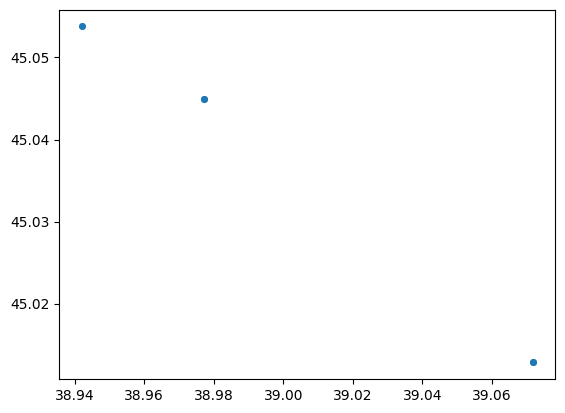

In [23]:
#сомтрим расположение филиалов
plt.scatter(df_manager.lon, df_manager.lat, s = 15)
plt.show()

In [24]:
#количество задач в разрезе функции
df_points['кто может ехать'].value_counts()

1,2      18
1,2,3    11
1         7
          6
Name: кто может ехать, dtype: int64

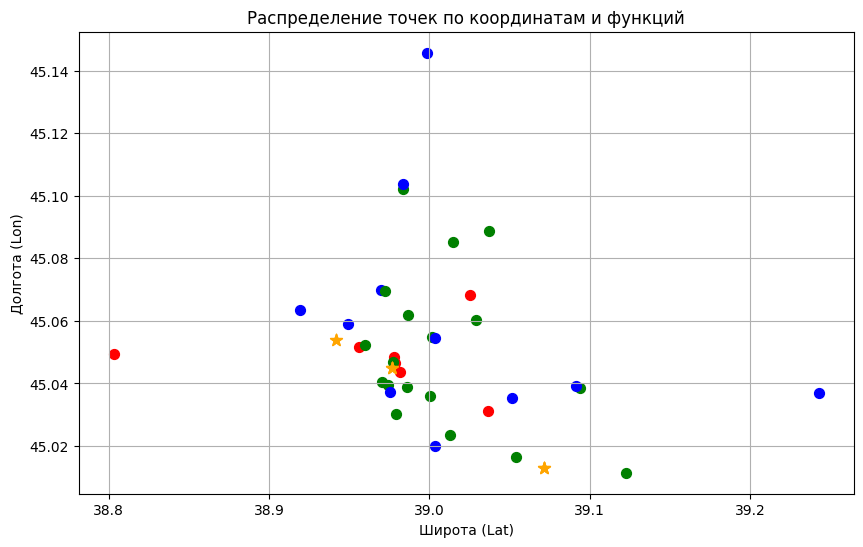

In [25]:
#Смотрим как располагаются филиалы (звездочки) и точки в разрезе приоритетности по цветам

# Определение цветов для каждого значения в столбце "Код функции"
colors = {'1': 'red', '1,2': 'green', '1,2,3' : 'blue'}

# Визуализация точек на графике
plt.figure(figsize=(10, 6))
for index, row in df_points[df_points['кто может ехать'] != ''].iterrows():
    plt.scatter(
        row['lon'], 
        row['lat'],
        color=colors.get(row['кто может ехать'], 'black'), 
        label=row['Адрес точки, г. Краснодар'], 
        s=50)

plt.scatter(x=df_manager.lon, y=df_manager.lat, c="orange", marker='*', s=80)
# Настройка графика
plt.xlabel('Широта (Lat)')
plt.ylabel('Долгота (Lon)')
plt.title('Распределение точек по координатам и функций')

plt.grid(True)
plt.show()

## Добавляем растояние от точек и приоритетность 

In [26]:
#определяет приоритет функции внутри приоритета
def priority_func(data, func):
    df_func = data[data[func] == 1].sort_values(
        by='одобренные но не выданные карты', ascending=False)
    # Нахождение максимального и минимального значения в столбце
    max_value = df_func['одобренные но не выданные карты'].max()
    min_value = df_func['одобренные но не выданные карты'].min()

    data[f'приоритет {func}'] = round(
        df_func['одобренные но не выданные карты'].apply(
            lambda x: (x - min_value) / (max_value - min_value) * len(df_func) + 1
            ), 2)

    return data

In [27]:
#Расчитываем приоритеты внутри проритета
for col in ['функция_1', 'функция_2', 'функция_3']:
    df_points = priority_func(df_points, col)
    df_points = df_points.fillna(0.0)
df_points

,№ точки,"Адрес точки, г. Краснодар",Когда подключена точка?,Карты и материалы доставлены?,Кол-во дней после выдачи последней карты,Кол-во одобренных заявок,Кол-во выданных карт,одобренные но не выданные карты,переход со вчерашнего дня,функция_1,функция_2,функция_3,кто может ехать,кол-во часов на точке,coordinates,lat,lon,приоритет функция_1,приоритет функция_2,приоритет функция_3
0,1,"ул. Ставропольская, д. 140",вчера,нет,0.0,0.0,0.0,0.0,0,0,0,1,"1,2,3",1.5,"(39.003879, 45.019844)",45.019844,39.003879,0.00,0.00,1.00
1,2,"ул. им. Максима Горького, д. 128",давно,да,3.0,15.0,3.0,12.0,0,0,1,0,"1,2",2.0,"(38.979517, 45.030113)",45.030113,38.979517,0.00,2.06,0.00
2,3,"ул. им. Дзержинского, д. 100",давно,да,3.0,9.0,1.0,8.0,0,0,1,0,"1,2",2.0,"(38.983856, 45.102209)",45.102209,38.983856,0.00,1.00,0.00
3,4,"ул. Красноармейская, д. 126",давно,да,0.0,38.0,23.0,15.0,0,0,0,0,,0.0,"(38.977244, 45.037961)",45.037961,38.977244,0.00,0.00,0.00
4,5,"х. Ленина, п/о. 37",давно,нет,0.0,14.0,0.0,14.0,0,0,0,1,"1,2,3",1.5,"(39.242822, 45.036904)",45.036904,39.242822,0.00,0.00,9.11
5,6,"тер. Пашковский жилой массив, ул. Крылатая, д. 2",давно,да,12.0,19.0,1.0,18.0,0,0,1,0,"1,2",2.0,"(39.122574, 45.01144)",45.01144,39.122574,0.00,3.65,0.00
6,7,"ул. Восточно-Кругликовская, д. 64/2",давно,да,27.0,19.0,12.0,7.0,0,1,0,0,1,4.0,"(39.025637, 45.068257)",45.068257,39.025637,2.56,0.00,0.00
7,8,"ул. Красных Партизан, д. 439",давно,да,33.0,84.0,63.0,21.0,0,1,0,0,1,4.0,"(38.956475, 45.051538)",45.051538,38.956475,8.00,0.00,0.00
8,9,"ул. Таманская, д. 153 к. 3, кв. 2",давно,да,2.0,15.0,1.0,14.0,0,0,1,0,"1,2",2.0,"(39.012809, 45.023609)",45.023609,39.012809,0.00,2.59,0.00
9,10,"ул. им. Дзержинского, д. 165",давно,да,0.0,19.0,0.0,19.0,0,0,0,0,,0.0,"(38.976481, 45.090285)",45.090285,38.976481,0.00,0.00,0.00


In [28]:
#соеденяем время и растояние до точек, первым присоеденяем всегда растояние df_pivot_length
df_points = pd.merge(df_points, df_pivot_length, on='Адрес точки, г. Краснодар', how='inner')
df_points = pd.merge(df_points, df_pivot_dur, on='Адрес точки, г. Краснодар', how='inner')
df_points

,№ точки,"Адрес точки, г. Краснодар",Когда подключена точка?,Карты и материалы доставлены?,Кол-во дней после выдачи последней карты,Кол-во одобренных заявок,Кол-во выданных карт,одобренные но не выданные карты,переход со вчерашнего дня,функция_1,функция_2,функция_3,кто может ехать,кол-во часов на точке,coordinates,lat,lon,приоритет функция_1,приоритет функция_2,приоритет функция_3,офис_2_x,офис_1_x,офис_3_x,"п. Березовый, ул. Целиноградская, д. 6/1_x","ст-ца. Елизаветинская, ул. Широкая, д. 260_x","тер. Пашковский жилой массив, ул. Крылатая, д. 2_x","ул. 1-го Мая, д. 268_x","ул. Восточно-Кругликовская, д. 64/2_x","ул. Зиповская, д. 1_x","ул. Коммунаров, д. 258_x","ул. Красная, д. 145_x","ул. Красная, д. 149_x","ул. Красная, д. 154_x","ул. Красная, д. 176_x","ул. Красноармейская, д. 126_x","ул. Красных Партизан, д. 117_x","ул. Красных Партизан, д. 439_x","ул. Российская, д. 418_x","ул. Северная, д. 326_x","ул. Северная, д. 327_x","ул. Северная, д. 389_x","ул. Северная, д. 524_x","ул. Ставропольская, д. 140_x","ул. Таманская, д. 153 к. 3, кв. 2_x","ул. Уральская, д. 117_x","ул. Уральская, д. 162_x","ул. Уральская, д. 166/3_x","ул. Уральская, д. 78_x","ул. Уральская, д. 79/1_x","ул. им. 40-летия Победы, д. 20/1_x","ул. им. 40-летия Победы, д. 34_x","ул. им. Атарбекова, д. 24_x","ул. им. Володи Головатого, д. 313_x","ул. им. Героя Аверкиева А.А., д. 8_x","ул. им. Дзержинского, д. 100_x","ул. им. Дзержинского, д. 101_x","ул. им. Дзержинского, д. 102_x","ул. им. Дзержинского, д. 165_x","ул. им. Кирилла Россинского, д. 61/1_x","ул. им. Максима Горького, д. 128_x","ул. им. Селезнева, д. 197/5_x","ул. им. Селезнева, д. 76_x","ул. им. Тургенева, д. 106_x","ул. им. Тургенева, д. 174, 1 этаж_x","х. Ленина, п/о. 37_x",офис_2_y,офис_1_y,офис_3_y,"п. Березовый, ул. Целиноградская, д. 6/1_y","ст-ца. Елизаветинская, ул. Широкая, д. 260_y","тер. Пашковский жилой массив, ул. Крылатая, д. 2_y","ул. 1-го Мая, д. 268_y","ул. Восточно-Кругликовская, д. 64/2_y","ул. Зиповская, д. 1_y","ул. Коммунаров, д. 258_y","ул. Красная, д. 145_y","ул. Красная, д. 149_y","ул. Красная, д. 154_y","ул. Красная, д. 176_y","ул. Красноармейская, д. 126_y","ул. Красных Партизан, д. 117_y","ул. Красных Партизан, д. 439_y","ул. Российская, д. 418_y","ул. Северная, д. 326_y","ул. Северная, д. 327_y","ул. Северная, д. 389_y","ул. Северная, д. 524_y","ул. Ставропольская, д. 140_y","ул. Таманская, д. 153 к. 3, кв. 2_y","ул. Уральская, д. 117_y","ул. Уральская, д. 162_y","ул. Уральская, д. 166/3_y","ул. Уральская, д. 78_y","ул. Уральская, д. 79/1_y","ул. им. 40-летия Победы, д. 20/1_y","ул. им. 40-летия Победы, д. 34_y","ул. им. Атарбекова, д. 24_y","ул. им. Володи Головатого, д. 313_y","ул. им. Героя Аверкиева А.А., д. 8_y","ул. им. Дзержинского, д. 100_y","ул. им. Дзержинского, д. 101_y","ул. им. Дзержинского, д. 102_y","ул. им. Дзержинского, д. 165_y","ул. им. Кирилла Россинского, д. 61/1_y","ул. им. Максима Горького, д. 128_y","ул. им. Селезнева, д. 197/5_y","ул. им. Селезнева, д. 76_y","ул. им. Тургенева, д. 106_y","ул. им. Тургенева, д. 174, 1 этаж_y","х. Ленина, п/о. 37_y"
0,1,"ул. Ставропольская, д. 140",вчера,нет,0.0,0.0,0.0,0.0,0,0,0,1,"1,2,3",1.5,"(39.003879, 45.019844)",45.019844,39.003879,0.00,0.00,1.00,7.16,6.25,9.18,23.08,21.25,11.26,7.84,8.23,9.35,5.45,6.14,6.79,4.94,6.0,4.91,11.26,8.0,10.5,5.60,4.49,4.29,5.0,NaN,1.25,8.19,8.48,8.58,3.93,5.30,6.97,7.76,9.83,5.75,7.28,13.26,10.27,14.83,11.28,11.87,3.71,4.98,2.97,7.93,10.23,20.66,0.19,0.21,0.28,0.51,0.53,0.3,0.25,0.25,0.29,0.17,0.19,0.22,0.16,0.18,0.15,0.35,0.25,0.31,0.20,0.13,0.13,0.14,NaN,0.05,0.23,0.25,0.25,0.11,0.18,0.25,0.24,0.31,0.2,0.23,0.42,0.32,0.37,0.35,0.39,0.12,0.15,0.08,0.24,0.32,0.41
1,2,"ул. им. Максима Горького, д. 128",давно,да,3.0,15.0,3.0,12.0,0,0,1,0,"1,2",2.0,"(38.979517, 45.030113)",45.030113,38.979517,0.00,2.06,0.00,11.65,2.86,5.68,19.67,17.84,15.75,8.04,8.43,5.94,1.97,2.73,3.38,1.55,2.6,1.53,7.85,4.59,10.02,2.22,1.37,1.87,2.48,4.49,5.74,9.98,10.27,10.37,5.52,7.09,4.55,4.73,6.42,2.34,7.47,9

In [29]:
points = df_points[df_points['функция_3'] == 1].sort_values(
        by='приоритет функция_3', 
        ascending=False
        )
points

,№ точки,"Адрес точки, г. Краснодар",Когда подключена точка?,Карты и материалы доставлены?,Кол-во дней после выдачи последней карты,Кол-во одобренных заявок,Кол-во выданных карт,одобренные но не выданные карты,переход со вчерашнего дня,функция_1,функция_2,функция_3,кто может ехать,кол-во часов на точке,coordinates,lat,lon,приоритет функция_1,приоритет функция_2,приоритет функция_3,офис_2_x,офис_1_x,офис_3_x,"п. Березовый, ул. Целиноградская, д. 6/1_x","ст-ца. Елизаветинская, ул. Широкая, д. 260_x","тер. Пашковский жилой массив, ул. Крылатая, д. 2_x","ул. 1-го Мая, д. 268_x","ул. Восточно-Кругликовская, д. 64/2_x","ул. Зиповская, д. 1_x","ул. Коммунаров, д. 258_x","ул. Красная, д. 145_x","ул. Красная, д. 149_x","ул. Красная, д. 154_x","ул. Красная, д. 176_x","ул. Красноармейская, д. 126_x","ул. Красных Партизан, д. 117_x","ул. Красных Партизан, д. 439_x","ул. Российская, д. 418_x","ул. Северная, д. 326_x","ул. Северная, д. 327_x","ул. Северная, д. 389_x","ул. Северная, д. 524_x","ул. Ставропольская, д. 140_x","ул. Таманская, д. 153 к. 3, кв. 2_x","ул. Уральская, д. 117_x","ул. Уральская, д. 162_x","ул. Уральская, д. 166/3_x","ул. Уральская, д. 78_x","ул. Уральская, д. 79/1_x","ул. им. 40-летия Победы, д. 20/1_x","ул. им. 40-летия Победы, д. 34_x","ул. им. Атарбекова, д. 24_x","ул. им. Володи Головатого, д. 313_x","ул. им. Героя Аверкиева А.А., д. 8_x","ул. им. Дзержинского, д. 100_x","ул. им. Дзержинского, д. 101_x","ул. им. Дзержинского, д. 102_x","ул. им. Дзержинского, д. 165_x","ул. им. Кирилла Россинского, д. 61/1_x","ул. им. Максима Горького, д. 128_x","ул. им. Селезнева, д. 197/5_x","ул. им. Селезнева, д. 76_x","ул. им. Тургенева, д. 106_x","ул. им. Тургенева, д. 174, 1 этаж_x","х. Ленина, п/о. 37_x",офис_2_y,офис_1_y,офис_3_y,"п. Березовый, ул. Целиноградская, д. 6/1_y","ст-ца. Елизаветинская, ул. Широкая, д. 260_y","тер. Пашковский жилой массив, ул. Крылатая, д. 2_y","ул. 1-го Мая, д. 268_y","ул. Восточно-Кругликовская, д. 64/2_y","ул. Зиповская, д. 1_y","ул. Коммунаров, д. 258_y","ул. Красная, д. 145_y","ул. Красная, д. 149_y","ул. Красная, д. 154_y","ул. Красная, д. 176_y","ул. Красноармейская, д. 126_y","ул. Красных Партизан, д. 117_y","ул. Красных Партизан, д. 439_y","ул. Российская, д. 418_y","ул. Северная, д. 326_y","ул. Северная, д. 327_y","ул. Северная, д. 389_y","ул. Северная, д. 524_y","ул. Ставропольская, д. 140_y","ул. Таманская, д. 153 к. 3, кв. 2_y","ул. Уральская, д. 117_y","ул. Уральская, д. 162_y","ул. Уральская, д. 166/3_y","ул. Уральская, д. 78_y","ул. Уральская, д. 79/1_y","ул. им. 40-летия Победы, д. 20/1_y","ул. им. 40-летия Победы, д. 34_y","ул. им. Атарбекова, д. 24_y","ул. им. Володи Головатого, д. 313_y","ул. им. Героя Аверкиева А.А., д. 8_y","ул. им. Дзержинского, д. 100_y","ул. им. Дзержинского, д. 101_y","ул. им. Дзержинского, д. 102_y","ул. им. Дзержинского, д. 165_y","ул. им. Кирилла Россинского, д. 61/1_y","ул. им. Максима Горького, д. 128_y","ул. им. Селезнева, д. 197/5_y","ул. им. Селезнева, д. 76_y","ул. им. Тургенева, д. 106_y","ул. им. Тургенева, д. 174, 1 этаж_y","х. Ленина, п/о. 37_y"
31,33,"ул. им. 40-летия Победы, д. 34",вчера,нет,0.0,19.0,0.0,19.0,0,0,0,1,"1,2,3",1.5,"(39.003736, 45.054684)",45.054684,39.003736,0.0,0.0,12.00,11.08,4.38,7.35,16.36,19.01,15.17,2.74,3.6,3.05,4.29,4.26,3.98,5.51,4.38,5.49,9.02,5.7,4.5,5.85,4.32,4.11,4.35,8.19,7.37,10.07,10.36,10.46,5.61,7.18,0.89,NaN,6.4,5.28,2.6,8.88,5.55,9.93,6.89,6.77,5.69,7.85,5.47,5.64,6.1,24.58,0.32,0.14,0.23,0.35,0.46,0.41,0.09,0.12,0.1,0.14,0.14,0.13,0.2,0.15,0.19,0.27,0.2,0.14,0.21,0.15,0.14,0.14,0.24,0.23,0.29,0.31,0.31,0.18,0.23,0.04,NaN,0.22,0.19,0.11,0.27,0.18,0.22,0.2,0.23,0.2,0.24,0.17,0.2,0.19,0.53
4,5,"х. Ленина, п/о. 37",давно,нет,0.0,14.0,0.0,14.0,0,0,0,1,"1,2,3",1.5,"(39.242822, 45.036904)",45.036904,39.242822,0.0,0.0,9.11,15.13,24.98,27.91,48.73,39.98,10.52,24.87,25.26,26.61,24.18,24.86,25.52,24.63,24.73,24.61,29.99,26.73,27.53,25.28,23.22,22.64,22.03,21.35,20.22,17.97,17.8,17.72,19.56,21.48,25.09,24.79,28.55,24

### Распределение точек между агентами

In [30]:
#Основная функция распределения точек между офисами и грейдами
def get_coordinate(df, num_office, func_list, func_priority, office_numbers, hours_points):

    #создаем датасета для функциональности 1
    data = df.copy()
    #норма офисов на все офисы выбранного грейда где есть эти грейды по количеству часов
    len_grade = round(office_numbers * 8 / hours_points)
    #количество офисов данного грейда отсортированные по приоритетности с выбранной функцией
    points = data[data[func_list[0]] == 1].sort_values(
        by=func_priority[0], 
        ascending=False
        )
    #если количество часов в офиса больше чем часов положенных на 2 офиса возращаем len_grade, если нет количество офисов с данной функцией
    data_len = (
        len_grade if (len(points) * hours_points) > (8 * office_numbers) 
        else len(points))
   
    #количество точек необходимых для данного грейда или сколько есть в датасете
    points = points[:data_len]
    #определяем норму часов на 1 агента
    normal_hours = (
        9 if len(points) * hours_points >= 8 * office_numbers
        else  math.ceil(len(points) * hours_points / office_numbers) + 1
        )

    coordinate = list()
    adress = list()
    task = list()
    lenth = list()
    hours_list = list()
    hours = 0
    df_office_mng = points.sort_values(by=num_office)
    adr = num_office[:-2] 
    idx = list()
    i = 0
   
    #Определяем координаты точек для заданного офиса по главномуу возможному/доступному для грейда приоритету
    while (len(df_office_mng) > 0) and (hours <= normal_hours):
        #присваиваем индекс минимальным растоянием
        index = df_office_mng.index[i]
        hours_agent = df_office_mng.loc[index]['кол-во часов на точке']
        duration = df_office_mng.loc[index][f'{adr}_y']
        
        if (hours + hours_agent + duration) > normal_hours:
            break
        else:
            lat_lon = [df_office_mng.loc[index]['lat'], df_office_mng.loc[index]['lon']]
            coordinate.append(lat_lon)  
            task.append(df_office_mng.loc[index]['кто может ехать'])
            adress_point = df_office_mng.loc[index]['Адрес точки, г. Краснодар']
            adress.append(adress_point)
            lenth.append(df_office_mng.loc[index][f'{adr}_x'])
            hours = hours + hours_agent + duration
            hours_list.append(hours_agent + duration)
            idx.append(index)
            points = points.drop(index=index)
            data = data.drop(index=index)

            df_office_mng = points.sort_values(
                by=f'{adress_point}_x'
            )
            adr = adress_point

    #Если часов не достаточно по основному приоритету ищем в приоритете на 1 грейд ниже
    if hours < 9 and len(func_list) > 2:
        points = data[data[func_list[1]] == 1].sort_values(by=func_priority[1], ascending=False)
        #points['близкий офис'] = points[office_list].idxmin(axis=1)
        df_office_mng = points.sort_values(by=num_office)
        while (len(df_office_mng) > 0) and (hours < normal_hours):
            #присваиваем индекс минимальным растоянием
            index = df_office_mng.index[i]
            hours_agent = df_office_mng.loc[index]['кол-во часов на точке']
            duration = df_office_mng.loc[index][f'{adr}_y']
            if (hours + hours_agent + duration) > normal_hours:
                break
            else:
                lat_lon = [df_office_mng.loc[index]['lat'], df_office_mng.loc[index]['lon']]
                coordinate.append(lat_lon)  
                adress_point = df_office_mng.loc[index]['Адрес точки, г. Краснодар']
                adress.append(adress_point)
                lenth.append(df_office_mng.loc[index][f'{adr}_x'])
                task.append(df_office_mng.loc[index]['кто может ехать'])
                hours = hours + hours_agent + duration
                hours_list.append(hours_agent + duration)
        
                idx.append(index)
                data = data.drop(index=index)
                points = points.drop(index=index)

                df_office_mng = points.sort_values(
                    by=f'{adress_point}_x'
                )
                adr = adress_point
    

    #Если часов не достаточно по основному приоритету ищем в приоритете на 2 грейда ниже
    if hours < 9 and len(func_list) > 2:
        points = data[data[func_list[2]] == 1].sort_values(by=func_priority[2], ascending=False)
        #points['близкий офис'] = points[office_list].idxmin(axis=1)
        df_office_mng = points.sort_values(by=num_office)
        
        while (len(df_office_mng) != 0) and (hours < normal_hours):
            #присваиваем индекс минимальным растоянием
            index = df_office_mng.index[i]
            hours_agent = df_office_mng.loc[index]['кол-во часов на точке']
            duration = df_office_mng.loc[index][f'{adr}_y']
            if (hours + hours_agent + duration) >= normal_hours:
                break
            else:
                lat_lon = [df_office_mng.loc[index]['lat'], df_office_mng.loc[index]['lon']]
                coordinate.append(lat_lon)  
                adress_point = df_office_mng.loc[index]['Адрес точки, г. Краснодар']
                adress.append(adress_point)
                lenth.append(df_office_mng.loc[index][f'{adr}_x'])
                task.append(df_office_mng.loc[index]['кто может ехать'])
                hours = hours + hours_agent + duration
                hours_list.append(hours_agent + duration)
    
                idx.append(index)
           
                data = data.drop(index=index)
                points = points.drop(index=index)

                df_office_mng = points.sort_values(
                    by=f'{adress_point}_x'
                )
                adr = adress_point
               

    return {'hours' : hours_list, 'coordinate' : coordinate, 'task' : task, 'adress' : adress, 'lenth' : lenth, 'idx' : idx}

In [31]:
#для изменения значений
def replace_value(value):
    return task_dict.get(value, value)

In [32]:
task_dict = {'1': 'Выезд на точку для стимулирования выдач', '1,2': 'Обучение агента', '1,2,3': 'Доставка карт и материалов'}
task_dict

{'1': 'Выезд на точку для стимулирования выдач',
 '1,2': 'Обучение агента',
 '1,2,3': 'Доставка карт и материалов'}

In [33]:
#Добаляем необходимые столбцы
df_manager['часы работы'] = 0
df_manager['список времени'] = [[] for _ in range(len(df_manager))]
df_manager['общее растояние (км)'] = 0
df_manager['список растояние (км)'] = [[] for _ in range(len(df_manager))]
df_manager['куда ехать адрес'] = [[] for _ in range(len(df_manager))]
df_manager['куда ехать координаты'] = [[] for _ in range(len(df_manager))]
df_manager['задачи на точке'] = [[] for _ in range(len(df_manager))]
df_manager

,ФИО,Адрес локации,Грейд,функции,офис,coordinates,lat,lon,часы работы,список времени,общее растояние (км),список растояние (км),куда ехать адрес,куда ехать координаты,задачи на точке
0,Дерягин Никита Владимирович,"Краснодар, Красная, д. 139",Синьор,"1, 2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,0,[],0,[],[],[],[]
1,Петрошев Валерий Павлович,"Краснодар, Красная, д. 139",Мидл,"2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,0,[],0,[],[],[],[]
2,Евдокимов Давид Тихонович,"Краснодар, Красная, д. 139",Джун,3,офис_1,"(38.977047, 45.04496)",45.04496,38.977047,0,[],0,[],[],[],[]
3,Андреев Гордий Данилович,"Краснодар, В.Н. Мачуги, 41",Синьор,"1, 2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,0,[],0,[],[],[],[]
4,Иванов Адам Федорович,"Краснодар, В.Н. Мачуги, 41",Мидл,"2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,0,[],0,[],[],[],[]
5,Бобылёв Ипполит Альбертович,"Краснодар, В.Н. Мачуги, 41",Джун,3,офис_2,"(39.071711, 45.012835)",45.012835,39.071711,0,[],0,[],[],[],[]
6,Беляева Евгения Антоновна,"Краснодар, Красных Партизан, 321",Мидл,"2, 3",офис_3,"(38.941986, 45.053773)",45.053773,38.941986,0,[],0,[],[],[],[]
7,Николаев Азарий Платонович,"Краснодар, Красных Партизан, 321",Джун,3,офис_3,"(38.941986, 45.053773)",45.053773,38.941986,0,[],0,[],[],[],[]


### Задачи для Синьоров

In [34]:
#Для добавления значений в датасет агентов
def put_data(df, manager, hours, lenth, coordinate, task, adress):
    df.loc[df['ФИО'] == manager, 'часы работы'] = sum(hours)
    df.loc[df['ФИО'] == manager, 'список времени'] = (
        df.loc[df['ФИО'] == manager, 'список времени']
        .map(lambda x: hours))
    df.loc[df['ФИО'] == manager, 'общее растояние (км)'] = sum(lenth)
    df.loc[df['ФИО'] == manager, 'список растояние (км)'] = (
        df.loc[df['ФИО'] == manager, 'список растояние (км)']
        .map(lambda x: lenth))    
    df.loc[df['ФИО'] == manager, 'куда ехать координаты'] = (
        df.loc[df['ФИО'] == manager, 'куда ехать координаты']
        .map(lambda x: coordinate))
    df.loc[df['ФИО'] == manager, 'куда ехать адрес'] = (
        df.loc[df['ФИО'] == manager, 'куда ехать адрес'].map(lambda x: adress))
    df.loc[df['ФИО'] == manager, 'задачи на точке'] = (
        df.loc[df['ФИО'] == manager, 'задачи на точке']
        .map(lambda x: list(map(replace_value, task))))
    return df

In [35]:
#Офис 1
vals_dicts = get_coordinate(
    df=df_points, 
    num_office='офис_1_x',
    func_list=['функция_1', 'функция_2', 'функция_3'], 
    func_priority=['приоритет функция_1', 'приоритет функция_2', 'приоритет функция_3'], 
    office_numbers=2,
    hours_points=4

)
df_points = df_points.drop(index=vals_dicts['idx'])
manager = (
    df_manager.loc[(df_manager['офис'] == 'офис_1') & 
    (df_manager['Грейд'] == 'Синьор'), 'ФИО'].values[0])
df_manager = put_data(
    df=df_manager, manager=manager, hours=vals_dicts['hours'], lenth=vals_dicts['lenth'],
    coordinate=vals_dicts['coordinate'], task=vals_dicts['task'], adress=vals_dicts['adress'])
df_manager

,ФИО,Адрес локации,Грейд,функции,офис,coordinates,lat,lon,часы работы,список времени,общее растояние (км),список растояние (км),куда ехать адрес,куда ехать координаты,задачи на точке
0,Дерягин Никита Владимирович,"Краснодар, Красная, д. 139",Синьор,"1, 2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,8.21,"[4.07, 4.14]",5.26,"[1.68, 3.58]","[ул. Коммунаров, д. 258, ул. Красных Партизан,...","[[45.043693, 38.981691], [45.051538, 38.956475]]","[Выезд на точку для стимулирования выдач, Выез..."
1,Петрошев Валерий Павлович,"Краснодар, Красная, д. 139",Мидл,"2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,0.00,[],0.00,[],[],[],[]
2,Евдокимов Давид Тихонович,"Краснодар, Красная, д. 139",Джун,3,офис_1,"(38.977047, 45.04496)",45.04496,38.977047,0.00,[],0.00,[],[],[],[]
3,Андреев Гордий Данилович,"Краснодар, В.Н. Мачуги, 41",Синьор,"1, 2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,0.00,[],0.00,[],[],[],[]
4,Иванов Адам Федорович,"Краснодар, В.Н. Мачуги, 41",Мидл,"2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,0.00,[],0.00,[],[],[],[]
5,Бобылёв Ипполит Альбертович,"Краснодар, В.Н. Мачуги, 41",Джун,3,офис_2,"(39.071711, 45.012835)",45.012835,39.071711,0.00,[],0.00,[],[],[],[]
6,Беляева Евгения Антоновна,"Краснодар, Красных Партизан, 321",Мидл,"2, 3",офис_3,"(38.941986, 45.053773)",45.053773,38.941986,0.00,[],0.00,[],[],[],[]
7,Николаев Азарий Платонович,"Краснодар, Красных Партизан, 321",Джун,3,офис_3,"(38.941986, 45.053773)",45.053773,38.941986,0.00,[],0.00,[],[],[],[]


In [36]:
#Офис 2
vals_dicts = get_coordinate(
    df=df_points, 
    num_office='офис_2_x',
    func_list=['функция_1', 'функция_2', 'функция_3'], 
    func_priority=['приоритет функция_1', 'приоритет функция_2', 'приоритет функция_3'], 
    office_numbers=1,
    hours_points=4

)
df_points = df_points.drop(index=vals_dicts['idx'])
manager = (
    df_manager.loc[(df_manager['офис'] == 'офис_2') & 
    (df_manager['Грейд'] == 'Синьор'), 'ФИО'].values[0])
df_manager = put_data(
    df=df_manager, manager=manager, hours=vals_dicts['hours'], lenth=vals_dicts['lenth'],
    coordinate=vals_dicts['coordinate'], task=vals_dicts['task'], adress=vals_dicts['adress'])
df_manager

,ФИО,Адрес локации,Грейд,функции,офис,coordinates,lat,lon,часы работы,список времени,общее растояние (км),список растояние (км),куда ехать адрес,куда ехать координаты,задачи на точке
0,Дерягин Никита Владимирович,"Краснодар, Красная, д. 139",Синьор,"1, 2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,8.21,"[4.07, 4.14]",5.26,"[1.68, 3.58]","[ул. Коммунаров, д. 258, ул. Красных Партизан,...","[[45.043693, 38.981691], [45.051538, 38.956475]]","[Выезд на точку для стимулирования выдач, Выез..."
1,Петрошев Валерий Павлович,"Краснодар, Красная, д. 139",Мидл,"2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,0.00,[],0.00,[],[],[],[]
2,Евдокимов Давид Тихонович,"Краснодар, Красная, д. 139",Джун,3,офис_1,"(38.977047, 45.04496)",45.04496,38.977047,0.00,[],0.00,[],[],[],[]
3,Андреев Гордий Данилович,"Краснодар, В.Н. Мачуги, 41",Синьор,"1, 2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,8.75,"[4.25, 4.5]",26.99,"[5.72, 21.27]","[ул. Уральская, д. 78, ст-ца. Елизаветинская, ...","[[45.031228, 39.036893], [45.049488, 38.803393]]","[Выезд на точку для стимулирования выдач, Выез..."
4,Иванов Адам Федорович,"Краснодар, В.Н. Мачуги, 41",Мидл,"2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,0.00,[],0.00,[],[],[],[]
5,Бобылёв Ипполит Альбертович,"Краснодар, В.Н. Мачуги, 41",Джун,3,офис_2,"(39.071711, 45.012835)",45.012835,39.071711,0.00,[],0.00,[],[],[],[]
6,Беляева Евгения Антоновна,"Краснодар, Красных Партизан, 321",Мидл,"2, 3",офис_3,"(38.941986, 45.053773)",45.053773,38.941986,0.00,[],0.00,[],[],[],[]
7,Николаев Азарий Платонович,"Краснодар, Красных Партизан, 321",Джун,3,офис_3,"(38.941986, 45.053773)",45.053773,38.941986,0.00,[],0.00,[],[],[],[]


### Задачи для Мидлов

In [37]:
#Офис 1
vals_dicts = get_coordinate(
    df=df_points, 
    num_office='офис_1_x', 
    func_list=['функция_2', 'функция_3'],
    func_priority=['приоритет функция_2', 'приоритет функция_3'],
    office_numbers=3,
    hours_points=2

)
df_points = df_points.drop(index=vals_dicts['idx'])
manager = (
    df_manager.loc[(df_manager['офис'] == 'офис_1') & 
    (df_manager['Грейд'] == 'Мидл'), 'ФИО'].values[0])
df_manager = put_data(
    df=df_manager, manager=manager, hours=vals_dicts['hours'], lenth=vals_dicts['lenth'],
    coordinate=vals_dicts['coordinate'], task=vals_dicts['task'], adress=vals_dicts['adress'])
df_manager

,ФИО,Адрес локации,Грейд,функции,офис,coordinates,lat,lon,часы работы,список времени,общее растояние (км),список растояние (км),куда ехать адрес,куда ехать координаты,задачи на точке
0,Дерягин Никита Владимирович,"Краснодар, Красная, д. 139",Синьор,"1, 2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,8.21,"[4.07, 4.14]",5.26,"[1.68, 3.58]","[ул. Коммунаров, д. 258, ул. Красных Партизан,...","[[45.043693, 38.981691], [45.051538, 38.956475]]","[Выезд на точку для стимулирования выдач, Выез..."
1,Петрошев Валерий Павлович,"Краснодар, Красная, д. 139",Мидл,"2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,8.27,"[2.05, 2.06, 2.06, 2.1]",5.88,"[1.21, 1.17, 0.9, 2.6]","[ул. Красная, д. 145, ул. им. Володи Головатог...","[[45.046718, 38.977685], [45.039464, 38.974307...","[Обучение агента, Обучение агента, Обучение аг..."
2,Евдокимов Давид Тихонович,"Краснодар, Красная, д. 139",Джун,3,офис_1,"(38.977047, 45.04496)",45.04496,38.977047,0.00,[],0.00,[],[],[],[]
3,Андреев Гордий Данилович,"Краснодар, В.Н. Мачуги, 41",Синьор,"1, 2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,8.75,"[4.25, 4.5]",26.99,"[5.72, 21.27]","[ул. Уральская, д. 78, ст-ца. Елизаветинская, ...","[[45.031228, 39.036893], [45.049488, 38.803393]]","[Выезд на точку для стимулирования выдач, Выез..."
4,Иванов Адам Федорович,"Краснодар, В.Н. Мачуги, 41",Мидл,"2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,0.00,[],0.00,[],[],[],[]
5,Бобылёв Ипполит Альбертович,"Краснодар, В.Н. Мачуги, 41",Джун,3,офис_2,"(39.071711, 45.012835)",45.012835,39.071711,0.00,[],0.00,[],[],[],[]
6,Беляева Евгения Антоновна,"Краснодар, Красных Партизан, 321",Мидл,"2, 3",офис_3,"(38.941986, 45.053773)",45.053773,38.941986,0.00,[],0.00,[],[],[],[]
7,Николаев Азарий Платонович,"Краснодар, Красных Партизан, 321",Джун,3,офис_3,"(38.941986, 45.053773)",45.053773,38.941986,0.00,[],0.00,[],[],[],[]


In [38]:
#Офис 2
vals_dicts = get_coordinate(
    df=df_points, num_office='офис_2_x', 
    func_list=['функция_2', 'функция_3'],
    func_priority=['приоритет функция_2', 'приоритет функция_3'],
    office_numbers=2,
    hours_points=2

)
df_points = df_points.drop(index=vals_dicts['idx'])
manager = (
    df_manager.loc[(df_manager['офис'] == 'офис_2') & 
    (df_manager['Грейд'] == 'Мидл'), 'ФИО'].values[0])
df_manager = put_data(
    df=df_manager, manager=manager, hours=vals_dicts['hours'], lenth=vals_dicts['lenth'],
    coordinate=vals_dicts['coordinate'], task=vals_dicts['task'], adress=vals_dicts['adress'])
df_manager

,ФИО,Адрес локации,Грейд,функции,офис,coordinates,lat,lon,часы работы,список времени,общее растояние (км),список растояние (км),куда ехать адрес,куда ехать координаты,задачи на точке
0,Дерягин Никита Владимирович,"Краснодар, Красная, д. 139",Синьор,"1, 2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,8.21,"[4.07, 4.14]",5.26,"[1.68, 3.58]","[ул. Коммунаров, д. 258, ул. Красных Партизан,...","[[45.043693, 38.981691], [45.051538, 38.956475]]","[Выезд на точку для стимулирования выдач, Выез..."
1,Петрошев Валерий Павлович,"Краснодар, Красная, д. 139",Мидл,"2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,8.27,"[2.05, 2.06, 2.06, 2.1]",5.88,"[1.21, 1.17, 0.9, 2.6]","[ул. Красная, д. 145, ул. им. Володи Головатог...","[[45.046718, 38.977685], [45.039464, 38.974307...","[Обучение агента, Обучение агента, Обучение аг..."
2,Евдокимов Давид Тихонович,"Краснодар, Красная, д. 139",Джун,3,офис_1,"(38.977047, 45.04496)",45.04496,38.977047,0.00,[],0.00,[],[],[],[]
3,Андреев Гордий Данилович,"Краснодар, В.Н. Мачуги, 41",Синьор,"1, 2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,8.75,"[4.25, 4.5]",26.99,"[5.72, 21.27]","[ул. Уральская, д. 78, ст-ца. Елизаветинская, ...","[[45.031228, 39.036893], [45.049488, 38.803393]]","[Выезд на точку для стимулирования выдач, Выез..."
4,Иванов Адам Федорович,"Краснодар, В.Н. Мачуги, 41",Мидл,"2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,8.92,"[2.17, 2.2, 2.32, 2.23]",32.18,"[5.43, 8.38, 10.83, 7.54]","[ул. Уральская, д. 162, тер. Пашковский жилой ...","[[45.038534, 39.094052], [45.01144, 39.122574]...","[Обучение агента, Обучение агента, Обучение аг..."
5,Бобылёв Ипполит Альбертович,"Краснодар, В.Н. Мачуги, 41",Джун,3,офис_2,"(39.071711, 45.012835)",45.012835,39.071711,0.00,[],0.00,[],[],[],[]
6,Беляева Евгения Антоновна,"Краснодар, Красных Партизан, 321",Мидл,"2, 3",офис_3,"(38.941986, 45.053773)",45.053773,38.941986,0.00,[],0.00,[],[],[],[]
7,Николаев Азарий Платонович,"Краснодар, Красных Партизан, 321",Джун,3,офис_3,"(38.941986, 45.053773)",45.053773,38.941986,0.00,[],0.00,[],[],[],[]


In [39]:
#Офис 3
vals_dicts = get_coordinate(
    df=df_points, 
    num_office='офис_3_x', 
    func_list=['функция_2', 'функция_3'],
    func_priority=['приоритет функция_2', 'приоритет функция_3'],
    office_numbers=1,
    hours_points=2

)
df_points = df_points.drop(index=vals_dicts['idx'])
manager = (
    df_manager.loc[(df_manager['офис'] == 'офис_3') & 
    (df_manager['Грейд'] == 'Мидл'), 'ФИО'].values[0])
df_manager = put_data(
    df=df_manager, manager=manager, hours=vals_dicts['hours'], lenth=vals_dicts['lenth'],
    coordinate=vals_dicts['coordinate'], task=vals_dicts['task'], adress=vals_dicts['adress'])
df_manager

,ФИО,Адрес локации,Грейд,функции,офис,coordinates,lat,lon,часы работы,список времени,общее растояние (км),список растояние (км),куда ехать адрес,куда ехать координаты,задачи на точке
0,Дерягин Никита Владимирович,"Краснодар, Красная, д. 139",Синьор,"1, 2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,8.21,"[4.07, 4.14]",5.26,"[1.68, 3.58]","[ул. Коммунаров, д. 258, ул. Красных Партизан,...","[[45.043693, 38.981691], [45.051538, 38.956475]]","[Выезд на точку для стимулирования выдач, Выез..."
1,Петрошев Валерий Павлович,"Краснодар, Красная, д. 139",Мидл,"2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,8.27,"[2.05, 2.06, 2.06, 2.1]",5.88,"[1.21, 1.17, 0.9, 2.6]","[ул. Красная, д. 145, ул. им. Володи Головатог...","[[45.046718, 38.977685], [45.039464, 38.974307...","[Обучение агента, Обучение агента, Обучение аг..."
2,Евдокимов Давид Тихонович,"Краснодар, Красная, д. 139",Джун,3,офис_1,"(38.977047, 45.04496)",45.04496,38.977047,0.00,[],0.00,[],[],[],[]
3,Андреев Гордий Данилович,"Краснодар, В.Н. Мачуги, 41",Синьор,"1, 2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,8.75,"[4.25, 4.5]",26.99,"[5.72, 21.27]","[ул. Уральская, д. 78, ст-ца. Елизаветинская, ...","[[45.031228, 39.036893], [45.049488, 38.803393]]","[Выезд на точку для стимулирования выдач, Выез..."
4,Иванов Адам Федорович,"Краснодар, В.Н. Мачуги, 41",Мидл,"2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,8.92,"[2.17, 2.2, 2.32, 2.23]",32.18,"[5.43, 8.38, 10.83, 7.54]","[ул. Уральская, д. 162, тер. Пашковский жилой ...","[[45.038534, 39.094052], [45.01144, 39.122574]...","[Обучение агента, Обучение агента, Обучение аг..."
5,Бобылёв Ипполит Альбертович,"Краснодар, В.Н. Мачуги, 41",Джун,3,офис_2,"(39.071711, 45.012835)",45.012835,39.071711,0.00,[],0.00,[],[],[],[]
6,Беляева Евгения Антоновна,"Краснодар, Красных Партизан, 321",Мидл,"2, 3",офис_3,"(38.941986, 45.053773)",45.053773,38.941986,8.58,"[2.18, 2.12, 2.16, 2.12]",16.55,"[4.4, 3.6, 5.45, 3.1]","[ул. им. Дзержинского, д. 101, ул. Зиповская, ...","[[45.069416, 38.972376], [45.061726, 38.986596...","[Обучение агента, Обучение агента, Обучение аг..."
7,Николаев Азарий Платонович,"Краснодар, Красных Партизан, 321",Джун,3,офис_3,"(38.941986, 45.053773)",45.053773,38.941986,0.00,[],0.00,[],[],[],[]


### Задачи для Джунов

In [40]:
#Офис 1
vals_dicts = get_coordinate(
    df=df_points, 
    num_office='офис_1_x', 
    func_list=['функция_3'],
    func_priority=['приоритет функция_3'], 
    office_numbers=3,
    hours_points=1.5

)
df_points = df_points.drop(index=vals_dicts['idx'])
manager = (
    df_manager.loc[(df_manager['офис'] == 'офис_1') & 
    (df_manager['Грейд'] == 'Джун'), 'ФИО'].values[0])
df_manager = put_data(
    df=df_manager, manager=manager, hours=vals_dicts['hours'], lenth=vals_dicts['lenth'],
    coordinate=vals_dicts['coordinate'], task=vals_dicts['task'], adress=vals_dicts['adress'])
df_manager

,ФИО,Адрес локации,Грейд,функции,офис,coordinates,lat,lon,часы работы,список времени,общее растояние (км),список растояние (км),куда ехать адрес,куда ехать координаты,задачи на точке
0,Дерягин Никита Владимирович,"Краснодар, Красная, д. 139",Синьор,"1, 2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,8.21,"[4.07, 4.14]",5.26,"[1.68, 3.58]","[ул. Коммунаров, д. 258, ул. Красных Партизан,...","[[45.043693, 38.981691], [45.051538, 38.956475]]","[Выезд на точку для стимулирования выдач, Выез..."
1,Петрошев Валерий Павлович,"Краснодар, Красная, д. 139",Мидл,"2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,8.27,"[2.05, 2.06, 2.06, 2.1]",5.88,"[1.21, 1.17, 0.9, 2.6]","[ул. Красная, д. 145, ул. им. Володи Головатог...","[[45.046718, 38.977685], [45.039464, 38.974307...","[Обучение агента, Обучение агента, Обучение аг..."
2,Евдокимов Давид Тихонович,"Краснодар, Красная, д. 139",Джун,3,офис_1,"(38.977047, 45.04496)",45.04496,38.977047,6.51,"[1.59, 1.68, 1.61, 1.63]",12.45,"[1.5, 4.51, 2.74, 3.7]","[ул. Красная, д. 154, ул. им. Тургенева, д. 17...","[[45.037165, 38.975636], [45.069792, 38.970211...","[Доставка карт и материалов, Доставка карт и м..."
3,Андреев Гордий Данилович,"Краснодар, В.Н. Мачуги, 41",Синьор,"1, 2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,8.75,"[4.25, 4.5]",26.99,"[5.72, 21.27]","[ул. Уральская, д. 78, ст-ца. Елизаветинская, ...","[[45.031228, 39.036893], [45.049488, 38.803393]]","[Выезд на точку для стимулирования выдач, Выез..."
4,Иванов Адам Федорович,"Краснодар, В.Н. Мачуги, 41",Мидл,"2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,8.92,"[2.17, 2.2, 2.32, 2.23]",32.18,"[5.43, 8.38, 10.83, 7.54]","[ул. Уральская, д. 162, тер. Пашковский жилой ...","[[45.038534, 39.094052], [45.01144, 39.122574]...","[Обучение агента, Обучение агента, Обучение аг..."
5,Бобылёв Ипполит Альбертович,"Краснодар, В.Н. Мачуги, 41",Джун,3,офис_2,"(39.071711, 45.012835)",45.012835,39.071711,0.00,[],0.00,[],[],[],[]
6,Беляева Евгения Антоновна,"Краснодар, Красных Партизан, 321",Мидл,"2, 3",офис_3,"(38.941986, 45.053773)",45.053773,38.941986,8.58,"[2.18, 2.12, 2.16, 2.12]",16.55,"[4.4, 3.6, 5.45, 3.1]","[ул. им. Дзержинского, д. 101, ул. Зиповская, ...","[[45.069416, 38.972376], [45.061726, 38.986596...","[Обучение агента, Обучение агента, Обучение аг..."
7,Николаев Азарий Платонович,"Краснодар, Красных Партизан, 321",Джун,3,офис_3,"(38.941986, 45.053773)",45.053773,38.941986,0.00,[],0.00,[],[],[],[]


In [41]:
#Офис 2
vals_dicts = get_coordinate(
    df=df_points, 
    num_office='офис_2_x', 
    func_list=['функция_3'],
    func_priority=['приоритет функция_3'],
    office_numbers=2,
    hours_points=1.5

)
df_points = df_points.drop(index=vals_dicts['idx'])
manager = (
    df_manager.loc[(df_manager['офис'] == 'офис_2') & 
    (df_manager['Грейд'] == 'Джун'), 'ФИО'].values[0])
df_manager = put_data(
    df=df_manager, manager=manager, hours=vals_dicts['hours'], lenth=vals_dicts['lenth'],
    coordinate=vals_dicts['coordinate'], task=vals_dicts['task'], adress=vals_dicts['adress'])
df_manager

,ФИО,Адрес локации,Грейд,функции,офис,coordinates,lat,lon,часы работы,список времени,общее растояние (км),список растояние (км),куда ехать адрес,куда ехать координаты,задачи на точке
0,Дерягин Никита Владимирович,"Краснодар, Красная, д. 139",Синьор,"1, 2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,8.21,"[4.07, 4.14]",5.26,"[1.68, 3.58]","[ул. Коммунаров, д. 258, ул. Красных Партизан,...","[[45.043693, 38.981691], [45.051538, 38.956475]]","[Выезд на точку для стимулирования выдач, Выез..."
1,Петрошев Валерий Павлович,"Краснодар, Красная, д. 139",Мидл,"2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,8.27,"[2.05, 2.06, 2.06, 2.1]",5.88,"[1.21, 1.17, 0.9, 2.6]","[ул. Красная, д. 145, ул. им. Володи Головатог...","[[45.046718, 38.977685], [45.039464, 38.974307...","[Обучение агента, Обучение агента, Обучение аг..."
2,Евдокимов Давид Тихонович,"Краснодар, Красная, д. 139",Джун,3,офис_1,"(38.977047, 45.04496)",45.04496,38.977047,6.51,"[1.59, 1.68, 1.61, 1.63]",12.45,"[1.5, 4.51, 2.74, 3.7]","[ул. Красная, д. 154, ул. им. Тургенева, д. 17...","[[45.037165, 38.975636], [45.069792, 38.970211...","[Доставка карт и материалов, Доставка карт и м..."
3,Андреев Гордий Данилович,"Краснодар, В.Н. Мачуги, 41",Синьор,"1, 2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,8.75,"[4.25, 4.5]",26.99,"[5.72, 21.27]","[ул. Уральская, д. 78, ст-ца. Елизаветинская, ...","[[45.031228, 39.036893], [45.049488, 38.803393]]","[Выезд на точку для стимулирования выдач, Выез..."
4,Иванов Адам Федорович,"Краснодар, В.Н. Мачуги, 41",Мидл,"2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,8.92,"[2.17, 2.2, 2.32, 2.23]",32.18,"[5.43, 8.38, 10.83, 7.54]","[ул. Уральская, д. 162, тер. Пашковский жилой ...","[[45.038534, 39.094052], [45.01144, 39.122574]...","[Обучение агента, Обучение агента, Обучение аг..."
5,Бобылёв Ипполит Альбертович,"Краснодар, В.Н. Мачуги, 41",Джун,3,офис_2,"(39.071711, 45.012835)",45.012835,39.071711,6.80,"[1.73, 1.6, 1.73, 1.74]",25.31,"[5.31, 3.62, 8.19, 8.19]","[ул. Уральская, д. 79/1, ул. Уральская, д. 117...","[[45.035273, 39.051463], [45.039203, 39.091735...","[Доставка карт и материалов, Доставка карт и м..."
6,Беляева Евгения Антоновна,"Краснодар, Красных Партизан, 321",Мидл,"2, 3",офис_3,"(38.941986, 45.053773)",45.053773,38.941986,8.58,"[2.18, 2.12, 2.16, 2.12]",16.55,"[4.4, 3.6, 5.45, 3.1]","[ул. им. Дзержинского, д. 101, ул. Зиповская, ...","[[45.069416, 38.972376], [45.061726, 38.986596...","[Обучение агента, Обучение агента, Обучение аг..."
7,Николаев Азарий Платонович,"Краснодар, Красных Партизан, 321",Джун,3,офис_3,"(38.941986, 45.053773)",45.053773,38.941986,0.00,[],0.00,[],[],[],[]


In [42]:
#Офис 3
vals_dicts = get_coordinate(
    df=df_points, 
    num_office='офис_3_x', 
    func_list=['функция_3'],
    func_priority=['приоритет функция_3'],
    office_numbers=1,
    hours_points=1.5

)
df_points = df_points.drop(index=vals_dicts['idx'])
manager = (
    df_manager.loc[(df_manager['офис'] == 'офис_3') & 
    (df_manager['Грейд'] == 'Джун'), 'ФИО'].values[0])
df_manager = put_data(
    df=df_manager, manager=manager, hours=vals_dicts['hours'], lenth=vals_dicts['lenth'],
    coordinate=vals_dicts['coordinate'], task=vals_dicts['task'], adress=vals_dicts['adress'])
df_manager

,ФИО,Адрес локации,Грейд,функции,офис,coordinates,lat,lon,часы работы,список времени,общее растояние (км),список растояние (км),куда ехать адрес,куда ехать координаты,задачи на точке
0,Дерягин Никита Владимирович,"Краснодар, Красная, д. 139",Синьор,"1, 2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,8.21,"[4.07, 4.14]",5.26,"[1.68, 3.58]","[ул. Коммунаров, д. 258, ул. Красных Партизан,...","[[45.043693, 38.981691], [45.051538, 38.956475]]","[Выезд на точку для стимулирования выдач, Выез..."
1,Петрошев Валерий Павлович,"Краснодар, Красная, д. 139",Мидл,"2, 3",офис_1,"(38.977047, 45.04496)",45.04496,38.977047,8.27,"[2.05, 2.06, 2.06, 2.1]",5.88,"[1.21, 1.17, 0.9, 2.6]","[ул. Красная, д. 145, ул. им. Володи Головатог...","[[45.046718, 38.977685], [45.039464, 38.974307...","[Обучение агента, Обучение агента, Обучение аг..."
2,Евдокимов Давид Тихонович,"Краснодар, Красная, д. 139",Джун,3,офис_1,"(38.977047, 45.04496)",45.04496,38.977047,6.51,"[1.59, 1.68, 1.61, 1.63]",12.45,"[1.5, 4.51, 2.74, 3.7]","[ул. Красная, д. 154, ул. им. Тургенева, д. 17...","[[45.037165, 38.975636], [45.069792, 38.970211...","[Доставка карт и материалов, Доставка карт и м..."
3,Андреев Гордий Данилович,"Краснодар, В.Н. Мачуги, 41",Синьор,"1, 2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,8.75,"[4.25, 4.5]",26.99,"[5.72, 21.27]","[ул. Уральская, д. 78, ст-ца. Елизаветинская, ...","[[45.031228, 39.036893], [45.049488, 38.803393]]","[Выезд на точку для стимулирования выдач, Выез..."
4,Иванов Адам Федорович,"Краснодар, В.Н. Мачуги, 41",Мидл,"2, 3",офис_2,"(39.071711, 45.012835)",45.012835,39.071711,8.92,"[2.17, 2.2, 2.32, 2.23]",32.18,"[5.43, 8.38, 10.83, 7.54]","[ул. Уральская, д. 162, тер. Пашковский жилой ...","[[45.038534, 39.094052], [45.01144, 39.122574]...","[Обучение агента, Обучение агента, Обучение аг..."
5,Бобылёв Ипполит Альбертович,"Краснодар, В.Н. Мачуги, 41",Джун,3,офис_2,"(39.071711, 45.012835)",45.012835,39.071711,6.80,"[1.73, 1.6, 1.73, 1.74]",25.31,"[5.31, 3.62, 8.19, 8.19]","[ул. Уральская, д. 79/1, ул. Уральская, д. 117...","[[45.035273, 39.051463], [45.039203, 39.091735...","[Доставка карт и материалов, Доставка карт и м..."
6,Беляева Евгения Антоновна,"Краснодар, Красных Партизан, 321",Мидл,"2, 3",офис_3,"(38.941986, 45.053773)",45.053773,38.941986,8.58,"[2.18, 2.12, 2.16, 2.12]",16.55,"[4.4, 3.6, 5.45, 3.1]","[ул. им. Дзержинского, д. 101, ул. Зиповская, ...","[[45.069416, 38.972376], [45.061726, 38.986596...","[Обучение агента, Обучение агента, Обучение аг..."
7,Николаев Азарий Платонович,"Краснодар, Красных Партизан, 321",Джун,3,офис_3,"(38.941986, 45.053773)",45.053773,38.941986,5.81,"[1.94, 1.63, 2.24]",64.43,"[9.28, 6.42, 48.73]","[ул. им. Дзержинского, д. 102, п. Березовый, у...","[[45.103787, 38.983928], [45.145759, 38.998561...","[Доставка карт и материалов, Доставка карт и м..."


### Визаул распределения точек

In [43]:
#Для построения графиков
def visual_coordinate(df, colors, office):
    plt.figure(figsize=(10, 8))
    for i, row in df.iterrows():
        d = np.array(row['куда ехать координаты'])
        plt.scatter(x=d[:, 1], y=d[:, 0], color=colors.get(row['ФИО'], 'pink'), s=35)

    if office == 1:
        plt.scatter(x=38.97704, y=45.044960, c="orange", marker='*', s=80)
        plt.scatter(x=39.071711, y=45.012835, c="yellow", marker='+', s=80)
        plt.scatter(x=38.941986, y=45.053773, c="yellow", marker='+', s=80)
    elif office == 2:
        plt.scatter(x=38.97704, y=45.044960, c="yellow", marker='+', s=80)
        plt.scatter(x=39.071711, y=45.012835, c="orange", marker='*', s=80)
        plt.scatter(x=38.941986, y=45.053773, c="yellow", marker='+', s=80)
    elif office == 3:
        plt.scatter(x=38.97704, y=45.044960, c="yellow", marker='+', s=80)
        plt.scatter(x=39.071711, y=45.012835, c="yellow", marker='+', s=80)
        plt.scatter(x=38.941986, y=45.053773, c="orange", marker='*', s=80)
    # Настройка графика
    plt.xlabel('Широта (Lat)')
    plt.ylabel('Долгота (Lon)')
    plt.title(f'Распределение точек по координатам и функций для офиса №{office}')

    plt.grid(True)
    plt.show()

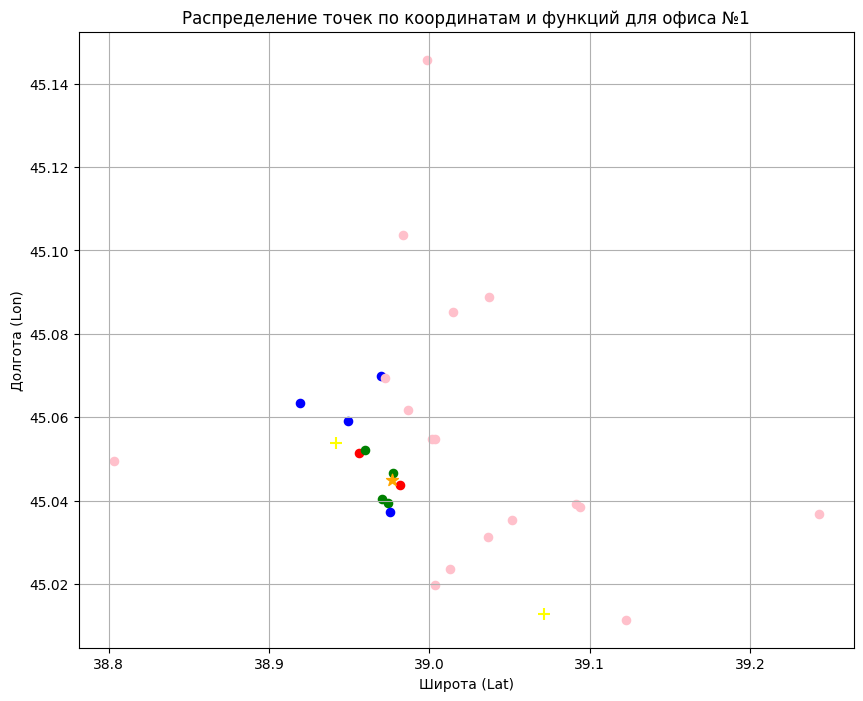

In [44]:
#ОФИС 1
colors = {
    'Дерягин Никита Владимирович': 'red',
    'Петрошев Валерий Павлович': 'green', 
    'Евдокимов Давид Тихонович' : 'blue'}
visual_coordinate(df_manager, colors, 1)

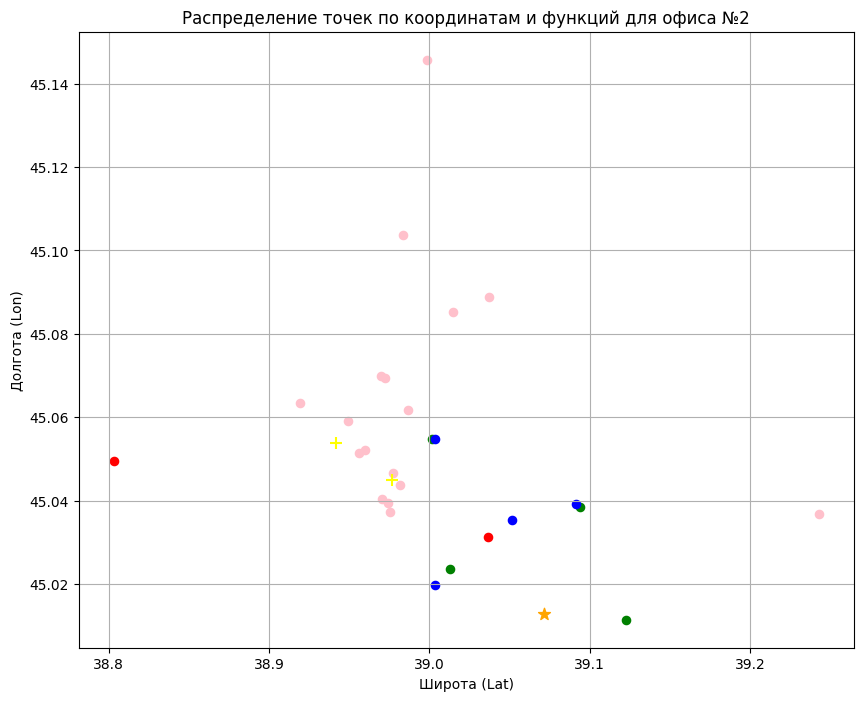

In [45]:
#ОФИС 2
colors = {
    'Андреев Гордий Данилович': 'red',
    'Иванов Адам Федорович': 'green', 
    'Бобылёв Ипполит Альбертович' : 'blue'}

visual_coordinate(df_manager, colors, 2)

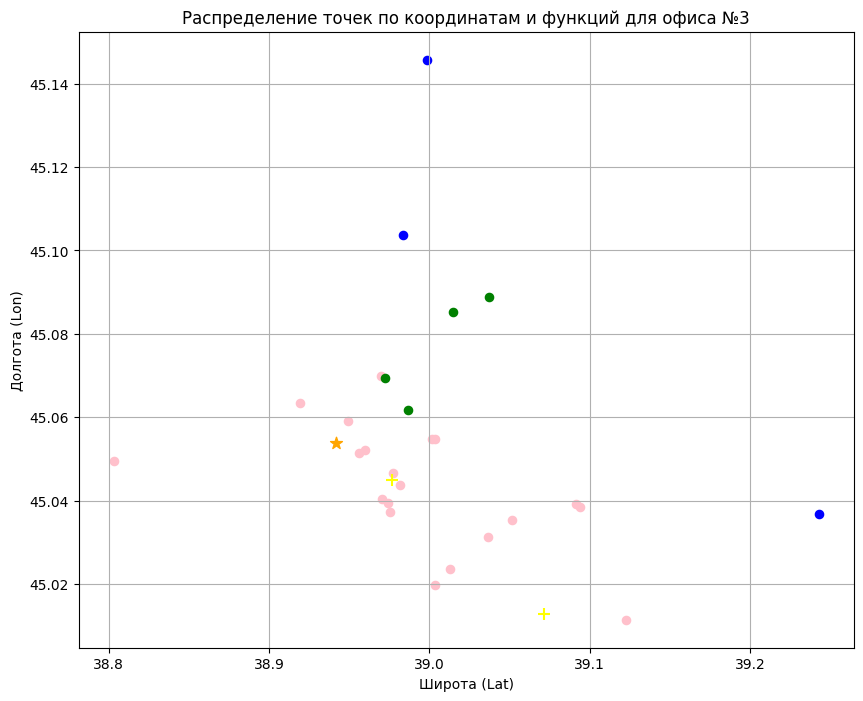

In [46]:
#ОФИС 3
colors = {
    'Беляева Евгения Антоновна': 'green', 
    'Николаев Азарий Платонович' : 'blue'}

# Визуализация точек на графике
visual_coordinate(df_manager, colors, 3)

In [47]:
df_manager.to_csv('4_ver_managers.csv')